# Analysis: Impact of Chatbot Usage on Student Performance

This notebook analyzes whether daily chatbot usage (`message_count`) influences students' performance scores using a Linear Mixed-Effects Model.

We use two datasets:
- `performances.csv`: test outcomes
- `user_days.csv`: daily chatbot activity and learning behavior

In [1]:
import pandas as pd
import statsmodels.formula.api as smf

# Load data
performances = pd.read_csv("data/features/performances.csv")
user_days = pd.read_csv("data/features/user_days.csv")

# Convert dates
performances["date"] = pd.to_datetime(performances["date"])
user_days["date"] = pd.to_datetime(user_days["date"])

In [11]:
performances.head()

,user_id,domain,test_id,course,date,time,percentage,performance
0,1,essay,eroerterung,3301,2024-11-29,2024-11-29 23:52:33,63.000000,-7.090000
1,1,essay,erzaehlung,5447,2024-10-26,2024-10-26 07:24:30,55.294118,-8.075882
2,4,essay,eroerterung,3301,2024-11-21,2024-11-21 17:23:46,66.000000,-4.090000
3,4,essay,erzaehlung,3301,2024-11-07,2024-11-07 16:13:25,71.000000,3.390000
4,5,essay,erzaehlung,5447,2024-10-26,2024-10-26 07:23:58,44.705882,-18.664118


In [12]:
user_days.head()

,user_id,date,type,user_day,number_of_activities,domain,activity_type,time_in_minutes,message_count
0,1,2024-10-26,both,1.0,2.0,essay,lesson,0.0,NaN
1,1,2024-10-30,activity,2.0,0.0,NaN,NaN,NaN,NaN
2,1,2024-10-31,activity,3.0,1.0,text,lesson,0.0,NaN
3,1,2024-11-01,activity,4.0,6.0,essay,lesson,0.0,NaN
4,1,2024-11-01,activity,4.0,6.0,text,lesson,0.0,NaN


## Model: Linear Mixed-Effects -> overall chatbot usage 

First we naively look at the relationship between the **total message count** for each user with the chatbot and performance

We fit a mixed model with:
- Fixed effect for `message_count`
- Random intercept per `user_id` to account for baseline performance differences

In [2]:
tot_messages = user_days.groupby(by='user_id')['message_count'].sum()

merged_tot_msg = pd.merge(performances, tot_messages, on=["user_id"], how="left")

merged_tot_msg.head()

,user_id,domain,test_id,course,date,time,percentage,performance,message_count
0,1,essay,eroerterung,3301,2024-11-29,2024-11-29 23:52:33,63.000000,-7.090000,16.0
1,1,essay,erzaehlung,5447,2024-10-26,2024-10-26 07:24:30,55.294118,-8.075882,16.0
2,4,essay,eroerterung,3301,2024-11-21,2024-11-21 17:23:46,66.000000,-4.090000,6.0
3,4,essay,erzaehlung,3301,2024-11-07,2024-11-07 16:13:25,71.000000,3.390000,6.0
4,5,essay,erzaehlung,5447,2024-10-26,2024-10-26 07:23:58,44.705882,-18.664118,0.0


In [3]:
# Fit mixed-effects model
model = smf.mixedlm("performance ~ message_count", merged_tot_msg, groups=merged_tot_msg["user_id"])
result = model.fit()
print(result.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: performance
No. Observations: 4836    Method:             REML       
No. Groups:       573     Scale:              469.9691   
Min. group size:  1       Log-Likelihood:     -22084.6564
Max. group size:  35      Converged:          Yes        
Mean group size:  8.4                                    
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      -0.281    0.963 -0.292 0.770 -2.168  1.605
message_count   0.009    0.012  0.772 0.440 -0.014  0.033
Group Var     184.062    0.758                           



•	The coefficient for message_count is 0.009, but it is not statistically significant (p = 0.44).

•	This suggests that a user’s **total number of chatbot messages sent across all days is not meaningfully associated with their performance on any given test**. This does not imply the chatbot is ineffective, total usage is a coarse measure and may overlook important timing effects.

## Model: Linear Mixed-Effects -> chatbot usage on the day of the test

Next, we look at the use of the chatbot **on the day of the test** 

We fit a mixed model with:
- Fixed effect for `message_count`
- Random intercept per `user_id` to account for baseline performance differences

In [4]:
# Merge on user_id and date
merged = pd.merge(performances, user_days, on=["user_id", "date"], how="left")

# Fill missing chatbot usage with 0
merged["message_count"] = merged["message_count"].fillna(0)
merged = merged.dropna(subset=["performance"])

In [5]:
# Fit mixed-effects model
model = smf.mixedlm("performance ~ message_count", merged, groups=merged["user_id"])
result = model.fit()
print(result.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: performance
No. Observations: 10755   Method:             REML       
No. Groups:       573     Scale:              411.1538   
Min. group size:  1       Log-Likelihood:     -48225.5997
Max. group size:  136     Converged:          Yes        
Mean group size:  18.8                                   
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       0.066    0.761  0.086 0.931 -1.427  1.558
message_count  -0.415    0.089 -4.651 0.000 -0.589 -0.240
Group Var     263.821    0.953                           



- The coefficient for `message_count` is **-0.415** and statistically significant (p < 0.001).
- This suggests that **each additional chatbot message on the day of the test is associated with a 0.42-point decrease** in performance.
- **Important Note**: This likely reflects **reverse causality** — struggling students might use the chatbot more often. This does not imply the chatbot has a negative effect.

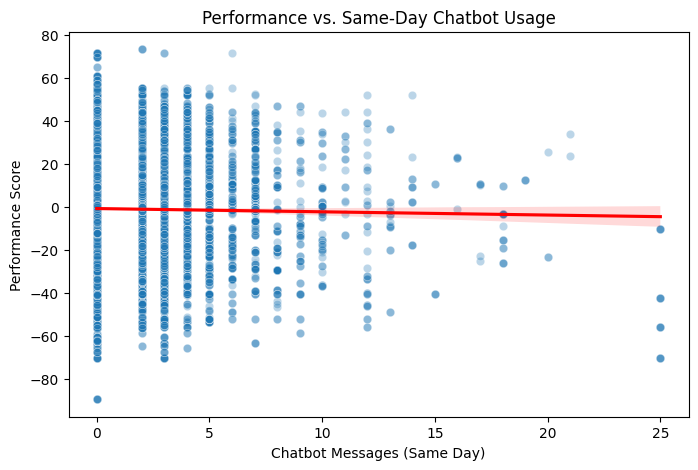

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Scatterplot with regression line: same-day chatbot use vs. performance
plt.figure(figsize=(8, 5))
sns.scatterplot(data=merged, x="message_count", y="performance", alpha=0.3)
sns.regplot(data=merged, x="message_count", y="performance", scatter=False, color="red")
plt.title("Performance vs. Same-Day Chatbot Usage")
plt.xlabel("Chatbot Messages (Same Day)")
plt.ylabel("Performance Score")
plt.show()

* There’s a negative linear trend: students who send more chatbot messages on the same day tend to perform slightly worse on that day’s test.
* This trend is consistent with the model’s results, but it does not prove causation — higher chatbot use may signal that a student was already struggling.

## Extended Analysis: Lagged Chatbot Use
To explore potential causal effects, we model **performance as a function of chatbot messages from the *previous day*** (`message_count_lag1`).

This helps distinguish between immediate effects and potential behavioral correlations (e.g. struggling students using the chatbot more).

In [7]:
# Create lagged chatbot use (previous day)
merged_sorted = merged.sort_values(by=["user_id", "date"])
merged_sorted["message_count_lag1"] = merged_sorted.groupby("user_id")["message_count"].shift(1)

# Drop rows where lag is missing
merged_lagged = merged_sorted.dropna(subset=["message_count_lag1", "performance"])

# Fit model
model_lagged = smf.mixedlm("performance ~ message_count_lag1", merged_lagged, groups=merged_lagged["user_id"])
result_lagged = model_lagged.fit()
print(result_lagged.summary())

            Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  performance
No. Observations:    10182    Method:              REML       
No. Groups:          537      Scale:               416.6853   
Min. group size:     1        Log-Likelihood:      -45714.8172
Max. group size:     135      Converged:           Yes        
Mean group size:     19.0                                     
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            0.050    0.795  0.063 0.950 -1.508  1.608
message_count_lag1  -0.405    0.091 -4.440 0.000 -0.583 -0.226
Group Var          265.834    0.989                           



- The coefficient for `message_count_lag1` is **-0.405** and statistically significant (p < 0.001).
- This suggests that **higher chatbot usage the day before a test is associated with lower performance**.
- Again, this likely reflects **reverse causality** — students who anticipate difficulty use the chatbot more.

## Multiple Lagged Chatbot Use
We now examine chatbot usage across the **three days prior to a test** to see how performance relates to past interaction patterns.

In [8]:
# Create lag features for previous 3 days
for lag in range(1, 4):
    merged_sorted[f"message_count_lag{lag}"] = merged_sorted.groupby("user_id")["message_count"].shift(lag)

# Drop rows with missing values
merged_multi_lagged = merged_sorted.dropna(subset=[
    "performance", "message_count_lag1", "message_count_lag2", "message_count_lag3"])

# Fit model
model_multi_lagged = smf.mixedlm(
    "performance ~ message_count_lag1 + message_count_lag2 + message_count_lag3",
    merged_multi_lagged,
    groups=merged_multi_lagged["user_id"]
)
result_multi_lagged = model_multi_lagged.fit()
print(result_multi_lagged.summary())

            Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  performance
No. Observations:    9157     Method:              REML       
No. Groups:          439      Scale:               419.5432   
Min. group size:     1        Log-Likelihood:      -41132.0319
Max. group size:     133      Converged:           Yes        
Mean group size:     20.9                                     
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            0.665    0.891  0.746 0.455 -1.081  2.410
message_count_lag1  -0.321    0.107 -3.008 0.003 -0.530 -0.112
message_count_lag2  -0.233    0.101 -2.320 0.020 -0.431 -0.036
message_count_lag3  -0.113    0.107 -1.057 0.291 -0.323  0.097
Group Var          275.154    1.094                           



- **Lag 1 day**: Coefficient = -0.321, significant (p = 0.003)
- **Lag 2 days**: Coefficient = -0.233, significant (p = 0.020)
- **Lag 3 days**: Coefficient = -0.113, not significant

**Interpretation:**
Recent chatbot use (especially 1–2 days before the test) is associated with slightly lower performance, but the effect weakens with time. This supports the idea that increased chatbot use might be a **response to anticipated difficulty**, rather than a cause of reduced performance.

## Visualizations
We visualize the relationship between chatbot usage and performance scores to gain further insight into the dynamics across time.

/var/folders/vx/vkjspthj6n57p5bz55t8lv_c0000gn/T/ipykernel_46008/3236508718.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_lagged["message_count_lag1_bucket"] = pd.cut(


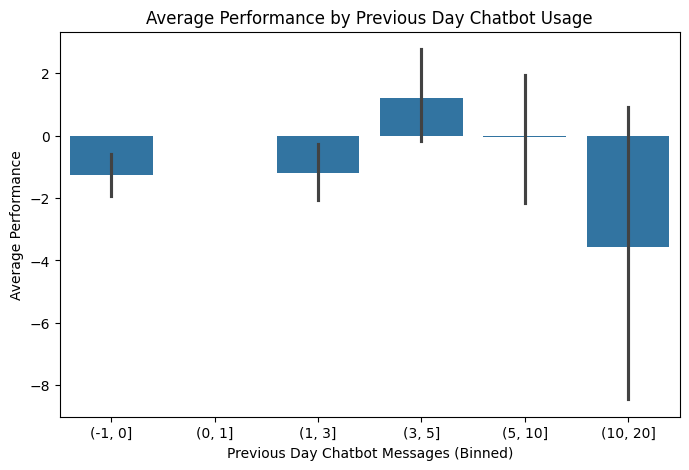

In [9]:
# Bar plot: average performance by previous day chatbot use (binned)
merged_lagged["message_count_lag1_bucket"] = pd.cut(
    merged_lagged["message_count_lag1"], bins=[-1, 0, 1, 3, 5, 10, 20], right=True
)
plt.figure(figsize=(8, 5))
sns.barplot(data=merged_lagged, x="message_count_lag1_bucket", y="performance")
plt.title("Average Performance by Previous Day Chatbot Usage")
plt.xlabel("Previous Day Chatbot Messages (Binned)")
plt.ylabel("Average Performance")
plt.show()

* Students who didn’t use the chatbot the day before tend to have slightly better performance on average.
* Moderate usage (1–3 messages) is associated with small dips in performance, while higher usage (>5 messages) shows more notable drops.
* This pattern supports the idea that students intensify chatbot use when anticipating difficulty.

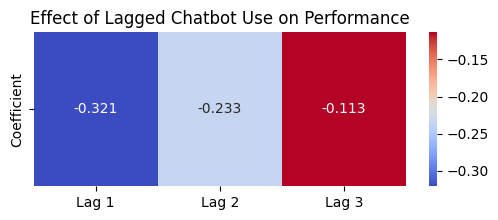

In [10]:
# Heatmap of coefficients from multi-lag model
lag_coefs = {
    "Lag 1": result_multi_lagged.params["message_count_lag1"],
    "Lag 2": result_multi_lagged.params["message_count_lag2"],
    "Lag 3": result_multi_lagged.params["message_count_lag3"],
}
plt.figure(figsize=(6, 2))
sns.heatmap(np.array([list(lag_coefs.values())]), annot=True, fmt=".3f", cmap="coolwarm",
            xticklabels=list(lag_coefs.keys()), yticklabels=["Coefficient"])
plt.title("Effect of Lagged Chatbot Use on Performance")
plt.show()

* The strongest effect comes from chatbot use 1 day before the test (coefficient ≈ -0.32).
* The effect weakens at 2 days and is not significant at 3 days.
* This suggests that very recent chatbot use is most correlated with performance, possibly reflecting short-term stress or preparation issues.